# 6. 영화 리뷰 텍스트 감성 분석하기
네이버 영화 리뷰 감성 분석 도전하기   
데이터셋 [Naver sentiment movie corpus](https://github.com/e9t/nsmc)   

## 데이터 가져오기

In [1]:
import pandas as pd
from tensorflow import keras
from konlpy.tag import Mecab
import numpy as np
from collections import Counter

import numpy as np
import tensorflow as tf
import os

import matplotlib.pyplot as plt

In [2]:
train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')

print("train_data: {}, test_data: {}".format(len(train_data), len(test_data)))
train_data[:5]

train_data: 150000, test_data: 50000


,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


## 데이터 전처리

- 데이터 중복 제거
- NaN 결측치 제거
- 한국어 토큰화
- stopwords 제거
- 사전 `word_to_index` 구성
- 텍스트 스트링을 사전 인덱스 스트링으로 변환
- `X_train, y_train, X_test, y_test, word_to_index` 리턴

In [3]:
tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    # 중복 데이터 삭제
    train_data.drop_duplicates(subset=['document'], inplace=True) 
    train_data = train_data.dropna(how = 'any') 
    test_data.drop_duplicates(subset=['document'], inplace=True) 
    test_data = test_data.dropna(how = 'any') 
    
    # 토큰화 하면서 stopwords에 해당하는 word 지우기
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence)
        temp_X = [word for word in temp_X if not word in stopwords]
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence)
        temp_X = [word for word in temp_X if not word in stopwords]
        X_test.append(temp_X)
    
    
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['<PAD>', '<BOS>', '<UNK>', ''] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)} # 많이 쓰이는 단어 딕셔너리 형태 단어사전으로 만들기
        
    
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index[''] for word in wordlist]
        
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
        
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index
    
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data) 

> vocab에 PAD, BOS, UNK를 추가했는데 또 어떤걸 추가해야할지 모르겠다.

In [4]:
print('train data: {}, test data: {}'.format(len(train_data), len(test_data)))
print(X_train[0])
print(X_test[0])
print(len(X_train), len(X_test))
# 단어 토큰화 및 정규화가 제대로 되었음을 볼 수 있다.

train data: 146183, test data: 49158
[32, 74, 919, 4, 4, 39, 228, 20, 33, 748]
[832, 130]
146182 49157


In [5]:
index_to_word = {index:word for word, index in word_to_index.items()}
dict(list(index_to_word.items())[:10])

{0: '<PAD>',
 1: '<BOS>',
 2: '<UNK>',
 3: '',
 4: '.',
 5: '영화',
 6: '다',
 7: '고',
 8: '하',
 9: '을'}

In [6]:
# 문장을 리스트의 숫자로 매핑하는 함수, 모든 문장은 <BOS>로 시작한다.
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 문장을 리스트의 숫자로 매핑하는 함수
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자로 매핑한 인코딩 문장을 디코딩해서 원래 문장으로 바꾼다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])

# 인코딩한 여러 문장을 디코딩해서 문장으로 바꾼다
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

In [7]:
i = 0
while i < 5:
    print('{} 번째 X_train is \n{}, \ny_train is \n{}\n'.format(i, get_decoded_sentence(X_train[i], index_to_word), y_train[i]))
    i += 1
train_data[:5]

0 번째 X_train is 
더 빙 . . 진짜 짜증 나 네요 목소리, 
y_train is 
0

1 번째 X_train is 
. .. 포스터 보고 초딩 영화 줄 . ... 오버 연기 조차 가볍 지 않 구나, 
y_train is 
1

2 번째 X_train is 
재 , 
y_train is 
0

3 번째 X_train is 
이야기 구먼 . . 솔직히 재미 없 다 . . 평점 조정, 
y_train is 
0

4 번째 X_train is 
익살 스런 연기 돋보였 던 영화 ! 스파이더맨 에서 늙 어 보이 기 만 했 던   너무나 이뻐 보였 다, 
y_train is 
1



,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [8]:
i = 0
while i < 5:
    print('{} 번째 X_test is \n{}, \ny_test is \n{}\n'.format(i, get_decoded_sentence(X_test[i], index_to_word), y_test[i]))
    i += 1
test_data[:5]

0 번째 X_test is 
ㅋ, 
y_test is 
1

1 번째 X_test is 
, 
y_test is 
0

2 번째 X_test is 
야 평점 . ... 나쁘 진 않 지만 10 점 짜리 더더욱 아니 잖아, 
y_test is 
0

3 번째 X_test is 
하 지 않 은데 완전 막장 임 . .. 돈 주 고 보 기 . ..., 
y_test is 
0

4 번째 X_test is 
D 만 아니 었 어도 별 다섯 개 줬 을 텐데 . . 왜 3 D 로 나와서 제  불편 하 게 하 죠 ? ?, 
y_test is 
0



,id,document,label
0,6270596,굳 ㅋ,1
1,9274899,GDNTOPCLASSINTHECLUB,0
2,8544678,뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0
3,6825595,지루하지는 않은데 완전 막장임... 돈주고 보기에는....,0
4,6723715,3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??,0


매핑이 제대로 되었는지 확인하는 과정에서 첫번째 단어와 stopwords에 해당하는 단어들을 자르면서 해석하기 어려운 문장들이 많이 생겼다. 나중에 이런 문장들도 빼거나 새롭게 토큰화, 전처리 하는 과정을 고려해야겠다.

## 데이터 분석 및 가공
- 데이터셋 내 문장 길이 분포 확인
- 적절한 최대 문장 길이 지정
- `keras.preprocessing.sequence.pad_sequences` 활용해서 패딩 추가

In [9]:
# 텍스트데이터 문장길이의 리스트를 생성한 후
total_data_text = list(X_train) + list(X_test)

num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)

# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 최대 길이를 평균 + 2 * 표준편차로 진행한다
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

문장길이 평균 :  15.96940191154864
문장길이 최대 :  116
문장길이 표준편차 :  12.843571191092
pad_sequences maxlen :  41
전체 문장의 0.9342988343341575%가 maxlen 설정값 이내에 포함됩니다. 


maxlen을 기준으로 보다 짧은 문장들은 앞에 `<PAD>`를 padding 해준다.

In [10]:
X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train,
                                                       value=word_to_index['<PAD>'],
                                                       padding='pre',
                                                       maxlen=maxlen)

X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index['<PAD>'],
                                                       padding='pre',
                                                       maxlen=maxlen)

print(X_train.shape, X_test.shape)

(146182, 41) (49157, 41)


## 모델과 validation set 구성
__3가지 이상 다양하게 구성해보기__

In [11]:
# RNN 모델 설계
vocab_size = 10000
word_vector_dim = 16  # 단어 하나를 표현하는 임베딩 벡터의 차원수이다.

model_RNN = tf.keras.Sequential()
model_RNN.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_RNN.add(tf.keras.layers.LSTM(8))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용했다.
model_RNN.add(tf.keras.layers.Dense(8, activation='relu'))
model_RNN.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 1dim이다.

model_RNN.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          160000    
_________________________________________________________________
lstm (LSTM)                  (None, 8)                 800       
_________________________________________________________________
dense (Dense)                (None, 8)                 72        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 160,881
Trainable params: 160,881
Non-trainable params: 0
_________________________________________________________________


In [12]:
# CNN
vocab_size = 10000
word_vector_dim = 16  # 단어 하나를 표현하는 임베딩 벡터의 차원수이다.

model_CNN = tf.keras.Sequential()
model_CNN.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_CNN.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model_CNN.add(tf.keras.layers.MaxPooling1D(5))
model_CNN.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model_CNN.add(tf.keras.layers.GlobalMaxPooling1D())
model_CNN.add(tf.keras.layers.Dense(8, activation='relu'))
model_CNN.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 1dim이다.

model_CNN.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
conv1d (Conv1D)              (None, None, 16)          1808      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 16)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 16)          1808      
_________________________________________________________________
global_max_pooling1d (Global (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                

In [13]:
# 하나의 GlobalMaxPooling
# 문장중 중요한 단어만 피처로 추출하여 평가하는 방식
vocab_size = 10000
word_vector_dim = 16  # 단어 하나를 표현하는 임베딩 벡터의 차원수이다.

model_GMP = tf.keras.Sequential()
model_GMP.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_GMP.add(tf.keras.layers.GlobalMaxPooling1D())
model_GMP.add(tf.keras.layers.Dense(8, activation='relu'))
model_GMP.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 1dim이다.

model_GMP.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 16)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 9         
Total params: 160,145
Trainable params: 160,145
Non-trainable params: 0
_________________________________________________________________


In [14]:
from sklearn.model_selection import train_test_split

train_input, train_target, test_input, test_target = train_test_split(X_train, y_train, test_size=0.2, random_state=5)

## 모델 훈련

In [15]:
model_RNN.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20

history_RNN = model_RNN.fit(train_input,
                    test_input,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(train_target, test_target),
                    verbose=1)

Epoch 1/20
229/229 [==============================] - 5s 8ms/step - loss: 0.5090 - accuracy: 0.7692 - val_loss: 0.3795 - val_accuracy: 0.8373
Epoch 2/20
229/229 [==============================] - 1s 6ms/step - loss: 0.3448 - accuracy: 0.8556 - val_loss: 0.3576 - val_accuracy: 0.8430
Epoch 3/20
229/229 [==============================] - 1s 5ms/step - loss: 0.3188 - accuracy: 0.8679 - val_loss: 0.3606 - val_accuracy: 0.8435
Epoch 4/20
229/229 [==============================] - 1s 6ms/step - loss: 0.3044 - accuracy: 0.8742 - val_loss: 0.3546 - val_accuracy: 0.8450
Epoch 5/20
229/229 [==============================] - 1s 5ms/step - loss: 0.2945 - accuracy: 0.8787 - val_loss: 0.3572 - val_accuracy: 0.8465
Epoch 6/20
229/229 [==============================] - 1s 6ms/step - loss: 0.2858 - accuracy: 0.8819 - val_loss: 0.3552 - val_accuracy: 0.8462
Epoch 7/20
229/229 [==============================] - 1s 5ms/step - loss: 0.2768 - accuracy: 0.8848 - val_loss: 0.3575 - val_accuracy: 0.8456
Epoch 

In [16]:
results_RNN = model_RNN.evaluate(X_test, y_test, verbose=2)

print(results_RNN)

1537/1537 - 3s - loss: 0.5058 - accuracy: 0.8417
[0.5058302879333496, 0.8416502475738525]


In [17]:
model_CNN.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20

history_CNN = model_CNN.fit(train_input,
                    test_input,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(train_target, test_target),
                    verbose=1)

Epoch 1/20
229/229 [==============================] - 3s 6ms/step - loss: 0.5464 - accuracy: 0.7226 - val_loss: 0.3801 - val_accuracy: 0.8336
Epoch 2/20
229/229 [==============================] - 1s 5ms/step - loss: 0.3353 - accuracy: 0.8575 - val_loss: 0.3513 - val_accuracy: 0.8478
Epoch 3/20
229/229 [==============================] - 1s 5ms/step - loss: 0.2966 - accuracy: 0.8772 - val_loss: 0.3481 - val_accuracy: 0.8509
Epoch 4/20
229/229 [==============================] - 1s 5ms/step - loss: 0.2689 - accuracy: 0.8905 - val_loss: 0.3524 - val_accuracy: 0.8504
Epoch 5/20
229/229 [==============================] - 1s 5ms/step - loss: 0.2405 - accuracy: 0.9038 - val_loss: 0.3635 - val_accuracy: 0.8509
Epoch 6/20
229/229 [==============================] - 1s 5ms/step - loss: 0.2112 - accuracy: 0.9183 - val_loss: 0.3857 - val_accuracy: 0.8491
Epoch 7/20
229/229 [==============================] - 1s 5ms/step - loss: 0.1813 - accuracy: 0.9322 - val_loss: 0.4168 - val_accuracy: 0.8441
Epoch 

In [18]:
results_CNN = model_CNN.evaluate(X_test, y_test, verbose=2)

print(results_CNN)

1537/1537 - 2s - loss: 0.9688 - accuracy: 0.8213
[0.9687602519989014, 0.8213072419166565]


In [19]:
model_GMP.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20

history_GMP = model_GMP.fit(train_input,
                    test_input,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(train_target, test_target),
                    verbose=1)

Epoch 1/20
229/229 [==============================] - 1s 4ms/step - loss: 0.5763 - accuracy: 0.7549 - val_loss: 0.4293 - val_accuracy: 0.8152
Epoch 2/20
229/229 [==============================] - 1s 3ms/step - loss: 0.3725 - accuracy: 0.8413 - val_loss: 0.3716 - val_accuracy: 0.8354
Epoch 3/20
229/229 [==============================] - 1s 3ms/step - loss: 0.3237 - accuracy: 0.8619 - val_loss: 0.3641 - val_accuracy: 0.8411
Epoch 4/20
229/229 [==============================] - 1s 3ms/step - loss: 0.2969 - accuracy: 0.8758 - val_loss: 0.3656 - val_accuracy: 0.8412
Epoch 5/20
229/229 [==============================] - 1s 3ms/step - loss: 0.2773 - accuracy: 0.8848 - val_loss: 0.3701 - val_accuracy: 0.8414
Epoch 6/20
229/229 [==============================] - 1s 3ms/step - loss: 0.2611 - accuracy: 0.8938 - val_loss: 0.3779 - val_accuracy: 0.8414
Epoch 7/20
229/229 [==============================] - 1s 4ms/step - loss: 0.2474 - accuracy: 0.9001 - val_loss: 0.3871 - val_accuracy: 0.8396
Epoch 

In [20]:
results_GMP = model_GMP.evaluate(X_test, y_test, verbose=2)

print(results_GMP)

1537/1537 - 2s - loss: 0.5321 - accuracy: 0.8245
[0.5321441888809204, 0.8245417475700378]


In [21]:
print(history_RNN.history.keys())
print(history_CNN.history.keys())
print(history_GMP.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


## Loss, Accuracy 결과 시각화

In [22]:
def plot_result(history_model):
    h = history_model
    plt.subplot(2, 1, 1)
    plt.plot(h.history['loss'])
    plt.plot(h.history['val_loss'])

    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['train', 'val'])

    plt.subplot(2, 1, 2)
    plt.plot(h.history['accuracy'])
    plt.plot(h.history['val_accuracy'])

    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.legend(['train', 'val'])

    plt.show()

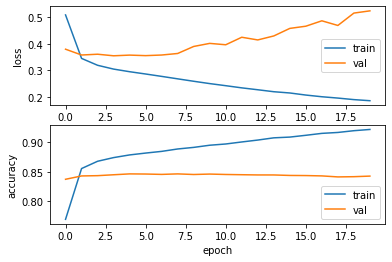

In [23]:
plot_result(history_RNN)

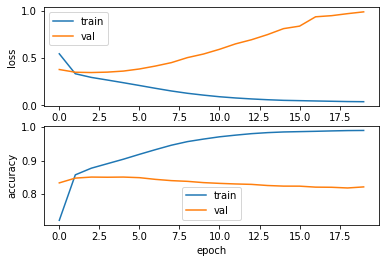

In [24]:
plot_result(history_CNN)

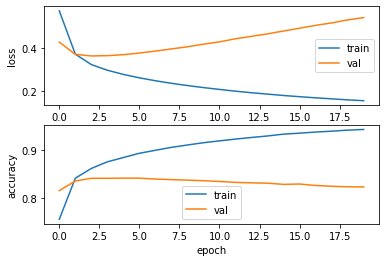

In [25]:
plot_result(history_GMP)

세 모델 다 1~2 에포크만에 loss값이 올라간다. 오버피팅이 심하게 되어있다. dropout같은 규제 레이어를 추가해서 오버피팅을 막는게 좋아보인다.

## Embedding 레이어 분석
accuracy가 가장 높은 `model_RNN` 레이어를 분석해보자

In [26]:
embedding_layer = model_RNN.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

(10000, 16)


In [27]:
# 학습한 Embedding 파라미터를 파일에 저장 
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/word2vec_ex.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록한다 
vectors = model_RNN.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [28]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['행복']
vector

array([ 0.29975075, -0.23446909,  0.03349094,  0.14570643,  0.04382025,
        0.11682716, -0.13700877, -0.1186693 ,  0.14202648, -0.04267547,
        0.02351303,  0.0129877 ,  0.28356996,  0.05788055,  0.24863358,
        0.04961135], dtype=float32)

'행복'이라는 단어가 백터로 저장되어 있음을 볼 수 있다.

In [29]:
word_vectors.similar_by_word('행복')

[('롤', 0.9682767391204834),
 ('내린', 0.9663150310516357),
 ('달콤', 0.9651921987533569),
 ('클래식', 0.9608426094055176),
 ('충이', 0.9606127738952637),
 ('잊', 0.9599027633666992),
 ('조디포스터', 0.9512983560562134),
 ('굳', 0.950629472732544),
 ('명언', 0.9503839015960693),
 ('일요일', 0.9470185041427612)]

'행복' 단어와 similar한 결과값을 가진 근처 벡터들을 보여주는 함수다. 그런데 결과가 연관성이 없다. 그래서 한국어가 많이 임베딩된 Word2Vec을 가져와서 테스트해보자.

## 한국어 Word2Vec 임베딩 활용해서 성능 개선해보기
[Pre-trained word vectors of 30+ languages](https://github.com/Kyubyong/wordvectors)   
`ko.bin` 이용하기, `gensim` 버전을 3.x.x으로 낮춰야 오류 발생하지 않음

In [30]:
!pip list | grep gensim

gensim                        3.8.1


In [31]:
!pip install --upgrade gensim==3.8.1

In [32]:
!pip list | grep gensim

gensim                        3.8.1


In [33]:
import gensim

In [34]:
word2vec_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/ko.bin'
word2vec = gensim.models.Word2Vec.load(word2vec_path)
# word2vec = KeyedVectors.load_word2vec_format(word2vec_path, binary=True, limit=1000000)
vector = word2vec['행복']
vector

/tmp/ipykernel_1222/2872938653.py:4: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  vector = word2vec['행복']


array([-9.37647521e-01,  3.84321630e-01,  2.66711020e+00, -4.90441829e-01,
       -1.87378454e+00,  7.46136725e-01,  2.06848055e-01,  1.17018402e+00,
        1.76071718e-01,  3.52754295e-01,  3.27339917e-01,  6.24713361e-01,
        4.98253882e-01, -2.54079252e-01,  1.86370641e-01,  5.02261400e-01,
        5.70066161e-02,  1.03963447e+00,  4.08005528e-02,  8.49552810e-01,
       -1.51971027e-01,  1.52919903e-01,  4.23378617e-01,  1.98788300e-01,
        1.94235623e+00, -2.86525309e-01,  4.72732335e-01, -2.14849854e+00,
       -1.26080573e+00, -1.48370254e+00, -7.26968274e-02, -5.65377235e-01,
       -1.09561288e+00, -8.93630147e-01,  8.22069585e-01, -4.43008691e-01,
        6.42822444e-01, -1.16659820e+00,  1.46968305e+00,  3.69109273e+00,
       -3.84803802e-01,  1.05108881e+00,  2.13611469e-01, -1.45143092e+00,
        5.02505243e-01,  7.05544576e-02,  1.83592427e+00, -6.79975271e-01,
        3.81043881e-01,  2.86220014e-01, -3.55438769e-01,  4.01191115e-02,
       -2.18128219e-01,  

In [35]:
word2vec.similar_by_word("행복")

/tmp/ipykernel_1222/898241355.py:1: DeprecationWarning: Call to deprecated `similar_by_word` (Method will be removed in 4.0.0, use self.wv.similar_by_word() instead).
  word2vec.similar_by_word("행복")


[('사랑', 0.6759077310562134),
 ('기쁨', 0.6493781805038452),
 ('즐거움', 0.6396492719650269),
 ('삶', 0.6299898028373718),
 ('젊음', 0.6187379360198975),
 ('즐겁', 0.6027448177337646),
 ('인생', 0.6002243161201477),
 ('존엄', 0.5952589511871338),
 ('고독', 0.5938762426376343),
 ('불행', 0.5894461870193481)]

similar한 데이터들만 나와서 단어 데이터셋의 가공 및 학습의 중요성을 다시 한번 느꼈다.

In [36]:
vector.shape

(200,)

In [37]:
vocab_size = 10000    # 어휘 사전 크기
word_vector_dim = 200  # 워드 벡터의 차원수
embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드 벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4,vocab_size):
    if index_to_word[i] in word2vec:
        embedding_matrix[i] = word2vec[index_to_word[i]]

/tmp/ipykernel_1222/330436182.py:7: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  if index_to_word[i] in word2vec:
/tmp/ipykernel_1222/330436182.py:8: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  embedding_matrix[i] = word2vec[index_to_word[i]]


In [38]:
embedding_matrix.shape

(10000, 200)

# 새로운 임베딩 데이터로 모델 학습 및 결과

임베딩의 차이를 보기 위해 레이어를 전에 진행했던 `model_RNN`, `model_CNN`, `model_GMP`와 동일하게 구성해서 학습해보고 결과를 봐보자

In [39]:
from tensorflow.keras.initializers import Constant


vocab_size = 10000
word_vector_dim = 200  # 단어 하나를 표현하는 임베딩 벡터의 차원수이다.

In [40]:
# new embedding RNN
model_new_RNN = tf.keras.Sequential()
model_new_RNN.add(tf.keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
model_new_RNN.add(tf.keras.layers.LSTM(8))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용했다.
model_new_RNN.add(tf.keras.layers.Dense(8, activation='relu'))
model_new_RNN.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 1dim이다.

model_new_RNN.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 41, 200)           2000000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 8)                 6688      
_________________________________________________________________
dense_6 (Dense)              (None, 8)                 72        
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 9         
Total params: 2,006,769
Trainable params: 2,006,769
Non-trainable params: 0
_________________________________________________________________


In [41]:
# new embedding CNN
model_new_CNN = tf.keras.Sequential()
model_new_CNN.add(tf.keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
model_new_CNN.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model_new_CNN.add(tf.keras.layers.MaxPooling1D(5))
model_new_CNN.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model_new_CNN.add(tf.keras.layers.GlobalMaxPooling1D())
model_new_CNN.add(tf.keras.layers.Dense(8, activation='relu'))
model_new_CNN.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 1dim이다.

model_new_CNN.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 41, 200)           2000000   
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 35, 16)            22416     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 7, 16)             0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 1, 16)             1808      
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 16)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_9 (Dense)              (None, 1)                

In [42]:
# new embedding GMP
model_new_GMP = tf.keras.Sequential()
model_new_GMP.add(tf.keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
model_new_GMP.add(tf.keras.layers.GlobalMaxPooling1D())
model_new_GMP.add(tf.keras.layers.Dense(8, activation='relu'))
model_new_GMP.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 1dim이다.

model_new_GMP.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 41, 200)           2000000   
_________________________________________________________________
global_max_pooling1d_3 (Glob (None, 200)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 8)                 1608      
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 9         
Total params: 2,001,617
Trainable params: 2,001,617
Non-trainable params: 0
_________________________________________________________________


In [43]:
model_new_RNN.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
early_stopping_cb = keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)

epochs=20

history_new_RNN = model_new_RNN.fit(train_input,
                    test_input,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(train_target, test_target),
                    verbose=1,
                    callbacks=[early_stopping_cb])

Epoch 1/20
229/229 [==============================] - 3s 8ms/step - loss: 0.5285 - accuracy: 0.7327 - val_loss: 0.4131 - val_accuracy: 0.8165
Epoch 2/20
229/229 [==============================] - 2s 7ms/step - loss: 0.3680 - accuracy: 0.8428 - val_loss: 0.3786 - val_accuracy: 0.8333
Epoch 3/20
229/229 [==============================] - 2s 7ms/step - loss: 0.3263 - accuracy: 0.8647 - val_loss: 0.3612 - val_accuracy: 0.8451
Epoch 4/20
229/229 [==============================] - 2s 7ms/step - loss: 0.3027 - accuracy: 0.8754 - val_loss: 0.3628 - val_accuracy: 0.8427
Epoch 5/20
229/229 [==============================] - 1s 7ms/step - loss: 0.2862 - accuracy: 0.8844 - val_loss: 0.3666 - val_accuracy: 0.8448
Epoch 6/20
229/229 [==============================] - 2s 7ms/step - loss: 0.2726 - accuracy: 0.8907 - val_loss: 0.3653 - val_accuracy: 0.8448


In [44]:
results_new_RNN = model_new_RNN.evaluate(X_test, y_test, verbose=2)

print(results_new_RNN)

1537/1537 - 3s - loss: 0.3611 - accuracy: 0.8458
[0.3611469864845276, 0.8458002209663391]


In [45]:
model_new_CNN.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
early_stopping_cb = keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)
              
epochs=20

history_new_CNN = model_new_CNN.fit(train_input,
                    test_input,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(train_target, test_target),
                    verbose=1,
                    callbacks=[early_stopping_cb])

Epoch 1/20
229/229 [==============================] - 3s 8ms/step - loss: 0.5370 - accuracy: 0.7196 - val_loss: 0.4469 - val_accuracy: 0.7914
Epoch 2/20
229/229 [==============================] - 1s 6ms/step - loss: 0.3906 - accuracy: 0.8260 - val_loss: 0.3862 - val_accuracy: 0.8288
Epoch 3/20
229/229 [==============================] - 1s 6ms/step - loss: 0.3304 - accuracy: 0.8588 - val_loss: 0.3672 - val_accuracy: 0.8413
Epoch 4/20
229/229 [==============================] - 1s 6ms/step - loss: 0.2933 - accuracy: 0.8793 - val_loss: 0.3650 - val_accuracy: 0.8430
Epoch 5/20
229/229 [==============================] - 1s 6ms/step - loss: 0.2658 - accuracy: 0.8917 - val_loss: 0.3696 - val_accuracy: 0.8445
Epoch 6/20
229/229 [==============================] - 1s 6ms/step - loss: 0.2402 - accuracy: 0.9044 - val_loss: 0.3776 - val_accuracy: 0.8426
Epoch 7/20
229/229 [==============================] - 1s 6ms/step - loss: 0.2174 - accuracy: 0.9153 - val_loss: 0.4003 - val_accuracy: 0.8370


In [46]:
results_new_CNN = model_new_CNN.evaluate(X_test, y_test, verbose=2)

print(results_new_CNN)

1537/1537 - 3s - loss: 0.3683 - accuracy: 0.8408
[0.36828574538230896, 0.8408365249633789]


In [47]:
model_new_GMP.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
early_stopping_cb = keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)


epochs=20

history_new_GMP = model_RNN.fit(train_input,
                    test_input,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(train_target, test_target),
                    verbose=1,
                    callbacks=[early_stopping_cb])

Epoch 1/20
229/229 [==============================] - 1s 6ms/step - loss: 0.1792 - accuracy: 0.9241 - val_loss: 0.5506 - val_accuracy: 0.8408
Epoch 2/20
229/229 [==============================] - 1s 6ms/step - loss: 0.1749 - accuracy: 0.9265 - val_loss: 0.5788 - val_accuracy: 0.8416
Epoch 3/20
229/229 [==============================] - 1s 6ms/step - loss: 0.1708 - accuracy: 0.9283 - val_loss: 0.5802 - val_accuracy: 0.8388
Epoch 4/20
229/229 [==============================] - 1s 5ms/step - loss: 0.1663 - accuracy: 0.9310 - val_loss: 0.5837 - val_accuracy: 0.8377


In [48]:
results_new_GMP = model_new_GMP.evaluate(X_test, y_test, verbose=2)

print(results_new_GMP)

1537/1537 - 2s - loss: 0.8567 - accuracy: 0.5141
[0.8567456603050232, 0.5141485333442688]


# 하이퍼 파라미터 세팅하기
정확도가 85% 이상이 되는게 목표이므로 `model_new_RNN`의 하이퍼 파라미터를 튜닝해보자

In [49]:
# new embedding RNN
model_new_RNN = tf.keras.Sequential()
model_new_RNN.add(tf.keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
model_new_RNN.add(tf.keras.layers.LSTM(64))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용했다.
model_new_RNN.add(tf.keras.layers.Dropout(0.3))
model_new_RNN.add(tf.keras.layers.Dense(8, activation='relu'))
model_new_RNN.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 1dim이다.


model_new_RNN.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 41, 200)           2000000   
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                67840     
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_12 (Dense)             (None, 8)                 520       
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 9         
Total params: 2,068,369
Trainable params: 2,068,369
Non-trainable params: 0
_________________________________________________________________


In [50]:
model_new_RNN.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
early_stopping_cb = keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)

epochs=20

history_new_RNN = model_new_RNN.fit(train_input,
                    test_input,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(train_target, test_target),
                    verbose=1,
                    callbacks=[early_stopping_cb])

Epoch 1/20
229/229 [==============================] - 4s 10ms/step - loss: 0.4879 - accuracy: 0.7564 - val_loss: 0.3789 - val_accuracy: 0.8326
Epoch 2/20
229/229 [==============================] - 2s 9ms/step - loss: 0.3457 - accuracy: 0.8507 - val_loss: 0.3445 - val_accuracy: 0.8506
Epoch 3/20
229/229 [==============================] - 2s 9ms/step - loss: 0.3039 - accuracy: 0.8719 - val_loss: 0.3301 - val_accuracy: 0.8576
Epoch 4/20
229/229 [==============================] - 2s 8ms/step - loss: 0.2772 - accuracy: 0.8849 - val_loss: 0.3292 - val_accuracy: 0.8581
Epoch 5/20
229/229 [==============================] - 2s 9ms/step - loss: 0.2577 - accuracy: 0.8945 - val_loss: 0.3303 - val_accuracy: 0.8581
Epoch 6/20
229/229 [==============================] - 2s 8ms/step - loss: 0.2397 - accuracy: 0.9025 - val_loss: 0.3362 - val_accuracy: 0.8595
Epoch 7/20
229/229 [==============================] - 2s 9ms/step - loss: 0.2235 - accuracy: 0.9101 - val_loss: 0.3429 - val_accuracy: 0.8590


In [51]:
results_new_RNN = model_new_RNN.evaluate(X_test, y_test, verbose=2)

print(results_new_RNN)

1537/1537 - 3s - loss: 0.3306 - accuracy: 0.8568
[0.3306002616882324, 0.8568057417869568]


### dropout 추가, LSTM(8) -> LSTM(64)로 목표치  accuracy 0.85 이상 달성했다!

# 회고


텍스트 데이터 토큰화랑 벡터로 정의하기, 전처리 과정이 꽤나 복잡하고 어려웠다.   
특히 load_data 클래스를 선언하는 과정에서 `vocab = ['<PAD>', '<BOS>', '<UNK>', '']` 이부분이 아이펠 코드 예시를 보면 아예 다 `''` 만 있고 빈칸으로 4번이던데, 이렇게 선언해도 괜찮을지 모르겠다.   

그리고 직접 임베딩한 결과물로 모델을 학습시킨것과 깃헙으로 공유된 임베딩이 크게 다른걸 보면 NLP는 임베딩 과정의 중요도가 5할정도는 되는거 같다.   
> 데이터 받아오기 -> ⭐️전처리(토큰화, 데이터 가공)⭐️ -> 모델 훈련, 학습 -> 결과 과정

